# Imports

In [221]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from variables import get_headers
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Petición a la API de Decathlon

In [164]:
def get_page_data(headers, payload):
    url = "https://www.decathlon.es/es/ajax/nfs/browse"
    response = requests.post(url, json=payload, headers=headers)
    response.raise_for_status()  # Asegurarse de manejar errores HTTP
    response = response.json()
    return response

## Prueba de petición y carga de primera página

In [222]:
payload, headers = get_headers(0)
response = get_page_data(headers, payload)
json_data = json.dumps(response)

print(json_data[:100])  # Muestra solo los primeros 100 caracteres


{"pager": {"blocks": 5460, "total": 137, "current": 0, "items": [{"id": "first", "from": 0, "size": 


# Creación del conjunto de datos a partir del JSON descubierto en la red de Decathlon

In [175]:
productos = []

total_pags = response['pager']['total']

for i in range(total_pags):
    payload, headers = get_headers(i * 40)
    response = get_page_data(headers,payload)
    
    items = response['blocks']['items']
    
    for item in items:
        brand = item['brand'].get('label', 'No disponible') #Marca
        web_label = item.get('webLabel', 'No disponible') #Etiqueta
        nature = item.get('natureLabel', 'No disponible') #Naturaleza del producto (tipo)
        
        model = item['models'][0] #Modelo
        price = model.get('price', 'No disponible') #Precio
        previous_price = model.get('previousPrice', 'No disponible') #Precio Previo
        currency = model.get('currency', 'No disponible') #Moneda
        discount_rate = model.get('discountRate', 'No disponible') #Porcentaje de descuento
        product_url = model.get('url', 'No disponible') #URL del producto
        image_url = model.get('image', {}).get('url', 'No disponible') #URL de la imagen
        
        productos.append({
            'Marca': brand,
            'Etiqueta Web': web_label,
            'Tipo Producto': nature,
            'Precio': price,
            'Precio Previo': previous_price,
            'Descuento Aplicado (en %)': discount_rate,
            'Image URL': image_url,
            'Product URL': product_url
        })

df_productos = pd.DataFrame(productos)

# Limpieza de datos

In [176]:
df = df_productos

### Veamos la forma de nuestro conjunto de datos

In [177]:
df.head(5)

,Marca,Etiqueta Web,Tipo Producto,Precio,Precio Previo,Descuento Aplicado (en %),Image URL,Product URL
0,CORENGTH,Estación Polea Musculación + Barra Tracción + ...,aparato de cargas guiadas,29.99,49.99,40,https://contents.mediadecathlon.com/p2185557/k...,p/estacion-polea-musculacion-barra-traccion-so...
1,INDIGO SPORTS,Banda Elástica (Cinta) cerrada 8 agarres INDIG...,Banda elástica,7.99,12.99,38,https://contents.mediadecathlon.com/m15108972/...,p/mp/indigo-sports/banda-elastica-cinta-cerrad...
2,DOMYOS,Malla Leggings fitness training hombre 500 negro,Leggings,9.99,11.99,16,https://contents.mediadecathlon.com/p1724978/k...,p/malla-leggings-fitness-training-hombre-500-n...
3,INDIGO SPORTS,Banda Elástica (Cinta) cerrada 8 agarres INDIG...,Banda elástica,7.99,12.99,38,https://contents.mediadecathlon.com/m15109719/...,p/mp/indigo-sports/banda-elastica-cinta-cerrad...
4,DOMYOS,Leggings Mujer Marrón Sin Costuras Efecto Push Up,Leggings,19.99,25.99,23,https://contents.mediadecathlon.com/p2732550/k...,p/leggings-mujer-marron-sin-costuras-efecto-pu...


### Veamos el tipo de dato de cada columna y el número de no nulos que hay

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5459 entries, 0 to 5458
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Marca                      5459 non-null   object 
 1   Etiqueta Web               5459 non-null   object 
 2   Tipo Producto              5459 non-null   object 
 3   Precio                     5459 non-null   float64
 4   Precio Previo              5459 non-null   object 
 5   Descuento Aplicado (en %)  5459 non-null   object 
 6   Image URL                  5459 non-null   object 
 7   Product URL                5459 non-null   object 
dtypes: float64(1), object(7)
memory usage: 341.3+ KB


### Cambiamos a númerico los datos que deberían de serlo

In [179]:
# Convertir precios y descuentos a tipo numérico
df["Precio"] = pd.to_numeric(df["Precio"], errors="coerce")
df["Precio Previo"] = pd.to_numeric(df["Precio Previo"], errors="coerce")
df["Descuento Aplicado (en %)"] = pd.to_numeric(df["Descuento Aplicado (en %)"], errors="coerce")

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5459 entries, 0 to 5458
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Marca                      5459 non-null   object 
 1   Etiqueta Web               5459 non-null   object 
 2   Tipo Producto              5459 non-null   object 
 3   Precio                     5459 non-null   float64
 4   Precio Previo              5375 non-null   float64
 5   Descuento Aplicado (en %)  5375 non-null   float64
 6   Image URL                  5459 non-null   object 
 7   Product URL                5459 non-null   object 
dtypes: float64(3), object(5)
memory usage: 341.3+ KB


### Veamos cuantos valores distintos tenemos en el conjunto de datos (por si hay que borrar duplicados)

In [183]:
distinct_product_urls = df['Product URL'].nunique()

# Mostrar el resultado
print(f"El número de valores distintos en 'Product URL' es: {distinct_product_urls}")
print(f'La longitud del data set: {len(df)}')


El número de valores distintos en 'Product URL' es: 5459
La longitud del data set: 5459


### Comprobemos si el descuento se aplica correctamente al precio de venta

In [ ]:
def verificar_descuento(row, margen_error=0.01):
    descuento_calculado = ((row["Precio Previo"] - row["Precio"]) / row["Precio Previo"]) * 100
    return abs(descuento_calculado - row["Descuento Aplicado (en %)"]) <= margen_error * 100

df["descuento_correcto"] = df.apply(verificar_descuento, axis=1)

num_true = df["descuento_correcto"].sum()
num_false = len(df) - num_true

print(f"Número de descuentos correctos: {num_true}")
print(f"Número de descuentos incorrectos: {num_false}")

5023
Número de descuentos correctos: 4939
Número de descuentos incorrectos: 84


### Parece ser que hay varios descuento que no se aplican correctamente, indaguemos más en el conjunto de datos

In [193]:
df_falsos = df[df["descuento_correcto"] == False]
print("\nProductos con descuentos incorrectos:")
df_falsos.head(5)


Productos con descuentos incorrectos:


,Marca,Etiqueta Web,Tipo Producto,Precio,Precio Previo,Descuento Aplicado (en %),Image URL,Product URL,descuento_correcto
50,VIRTUFIT,Disco de pesas - Disco de parachoques - Fitnes...,Discos de pesas de musculación,30.95,NaN,NaN,https://contents.mediadecathlon.com/m16730923/...,p/mp/virtufit/disco-de-pesas-disco-de-parachoq...,False
74,VIRTUFIT,Mancuerna Hexágono - Dumbbell - Por pieza - 1 ...,pesas ; mancuernas,13.95,NaN,NaN,https://contents.mediadecathlon.com/m16733029/...,p/mp/virtufit/mancuerna-hexagono-dumbbell-por-...,False
111,ECRAN,Crema solar Sport cara y cuerpo F50 40 ml,Crema solar,7.25,NaN,NaN,https://contents.mediadecathlon.com/p2044348/k...,p/crema-solar-sport-cara-y-cuerpo-f50-40-ml/_/...,False
127,VIRTUFIT,Mikebell - entrenamiento funcional - Negro,masa,40.95,NaN,NaN,https://contents.mediadecathlon.com/m19666108/...,p/mp/virtufit/mikebell-entrenamiento-funcional...,False
151,FITNESS TECH,Multipower Smith Machine S9000 Fitness Tech,aparato multifunción,1899.99,NaN,NaN,https://contents.mediadecathlon.com/m19026435/...,p/mp/fitness-tech/multipower-smith-machine-s90...,False


In [195]:
# Comprobar si los descuentos aplicados son NaN en df_falsos
descuentos_nan = df_falsos["Descuento Aplicado (en %)"].isna().all()
print(f"¿Todos los descuentos aplicados en df_falsos son NaN?: {descuentos_nan}")

¿Todos los descuentos aplicados en df_falsos son NaN?: True


# AED

## Ordenemos el conjunto de datos por el descuento aplicado ordenado de mayor a menor

In [209]:
df_sorted = df.sort_values(by="Descuento Aplicado (en %)", ascending=False)
print("\nDataFrame ordenado por mayor descuento aplicado:")
print(df_sorted[["Marca", "Etiqueta Web","Descuento Aplicado (en %)"]])


DataFrame ordenado por mayor descuento aplicado:
                Marca                                       Etiqueta Web  \
1295             AMIX  CellUp Energy Shot - 60ml Cola de AmiXpro® series   
1294             AMIX  CellUp Energy Shot - 60ml Cola de AmiXpro® series   
4233    MMSUPPLEMENTS  Cafeína - 120 Cápsulas Vegetales de MM Supplem...   
514    AESTHETIC WOLF  Aesthetic Wolf Camiseta de Oración - Hombre - ...   
1267  NORTHERN SPIRIT  Camiseta mujer rayas logo Northern Spirit Fren...   
...               ...                                                ...   
5436          PHOENIX    Botella Fitness Negro Blanco Motivación 1 Litro   
5447      SLENDERTONE                     Cinturón abdominal ABS7 unisex   
5449          BIEMANS                           MEDALLA NEUTRA 70 mm ORO   
5454           DOMYOS  Sujetador-Top Mujer Negro Espalda Cruzada Suje...   
5455           DOMYOS  Pantalón Corto Fitness Amarillo Pastel Bolsill...   

      Descuento Aplicado (en %)  
129

## Veamos si existe alguna relación entre el descuento aplicado y el precio del producto

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


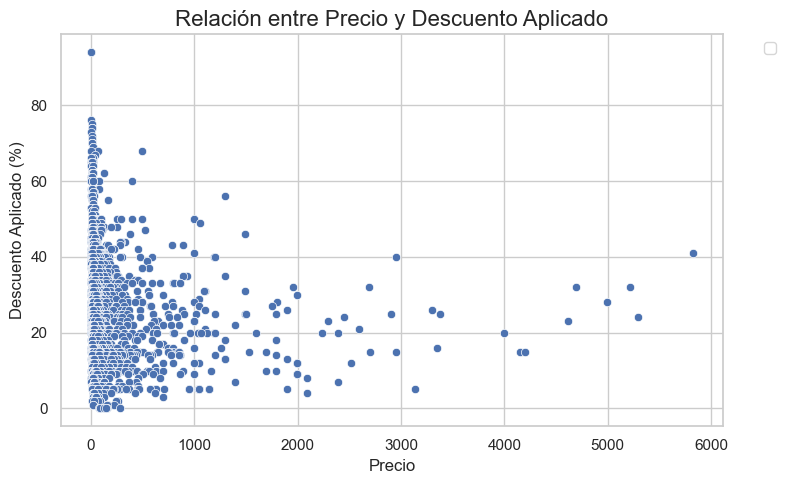

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x="Precio",
    y="Descuento Aplicado (en %)",
    data=df_sorted
)

plt.title("Relación entre Precio y Descuento Aplicado", fontsize=16)
plt.xlabel("Precio", fontsize=12)
plt.ylabel("Descuento Aplicado (%)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Realizamos una prueba anova rápida para ver si hay variables que influyen en el Descuento Aplicado

In [219]:
# Realizar ANOVA
df = df.rename(columns={"Descuento Aplicado (en %)": "Descuento_Aplicado", 'Tipo Producto':'Tipo_Producto'})
modelo = ols("Descuento_Aplicado ~ C(Marca) + C(Tipo_Producto) + Precio", data=df).fit()
anova_resultados = anova_lm(modelo)

print("Resultados del ANOVA:")
print(anova_resultados)

# Interpretar los resultados
for factor, p_valor in anova_resultados["PR(>F)"].items():
    if p_valor < 0.05:
        print(f"El factor '{factor}' tiene un efecto significativo en el descuento aplicado (p = {p_valor:.4f}).")
    else:
        print(f"El factor '{factor}' no tiene un efecto significativo en el descuento aplicado (p = {p_valor:.4f}).")

Resultados del ANOVA:
                      df         sum_sq      mean_sq          F        PR(>F)
C(Marca)           249.0  414513.430124  1664.712571  23.003618  0.000000e+00
C(Tipo_Producto)   256.0   52788.902738   206.206651   2.849440  3.769950e-42
Precio               1.0    3291.028042  3291.028042  45.476651  1.742258e-11
Residual          4453.0  322252.134900    72.367423        NaN           NaN
El factor 'C(Marca)' tiene un efecto significativo en el descuento aplicado (p = 0.0000).
El factor 'C(Tipo_Producto)' tiene un efecto significativo en el descuento aplicado (p = 0.0000).
El factor 'Precio' tiene un efecto significativo en el descuento aplicado (p = 0.0000).
El factor 'Residual' no tiene un efecto significativo en el descuento aplicado (p = nan).


# Exportamos el conjunto de datos ordenado por Descuento Aplicado a un documento CSV

In [220]:
df_sorted.to_csv('productos_paginas.csv', index=False, encoding='utf-8')

print("Datos exportados a 'productos_paginas.csv'")


Datos exportados a 'productos_paginas.csv'
